In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import yaml
import numpy as np
from pathlib import Path
from scripts.utils import DataLoader
from models.transformer import Transformer
from models.genfactor import GenFactor
from models.mlp import MLP
import pandas as pd
import os
from tqdm import tqdm

WORK_PATH = Path.cwd()
FILE_PATH = WORK_PATH / Path('configs/mlp.yml')
print(FILE_PATH)
with open(FILE_PATH, 'r') as file:
    args = yaml.safe_load(file)
dl = DataLoader(args, 'cuda')

/content/drive/MyDrive/colab/AFP-GenFactor
/content/drive/MyDrive/colab/AFP-GenFactor/configs/mlp.yml


In [5]:
model_name = 'mlp'
year = 2020
dir =   "results/" + "save_model" + f"/{model_name}" + f"/{int(year)}/" + "best_model_" + f"{model_name}-v2.ckpt"
print(dir)
checkpoint = torch.load(dir, map_location=torch.device('cpu'))
model = MLP(model_name,dl, args)
state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

results/save_model/mlp/2020/best_model_mlp-v2.ckpt


<All keys matched successfully>

In [4]:
def load_model(model_name, year, dl):
    dir =   "results/" + "save_model" + f"/{model_name}" + f"/{int(year)}/" + "best_model_" + f"{model_name}-v2.ckpt"
    model_name = 'mlp'
    year = 2020
    dir =   "results/" + "save_model" + f"/{model_name}" + f"/{int(year)}/" + "best_model_" + f"{model_name}-v2.ckpt"
    print(dir)
    checkpoint = torch.load(dir, map_location=torch.device('cpu'))
    state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}

    if model_name == 'mlp':
        model = MLP(model_name,dl, args)
        model.load_state_dict(state_dict)
    elif model_name == 'transformer':
        model = Transformer(model_name, dl, args)
        model.model.load_state_dict(state_dict)
    elif model_name == 'genfactor':
        model = GenFactor(model_name,dl, args)
        model.model.load_state_dict(state_dict)
    return model

mlp_model = load_model('mlp', 2020, dl)

results/save_model/mlp/2020/best_model_mlp-v2.ckpt


In [38]:
def cal_attr(model, input_data):
    integrated_gradients = IntegratedGradients(model.cuda())
    attributions_ig = integrated_gradients.attribute(input_data.cuda(), n_steps=1)
    attr = attributions_ig[:,:,-1].permute(1,0).mean(dim=0)
    return attr.detach().cpu().numpy()

torch.Size([414, 82, 20])


<function matplotlib.pyplot.show(close=None, block=None)>

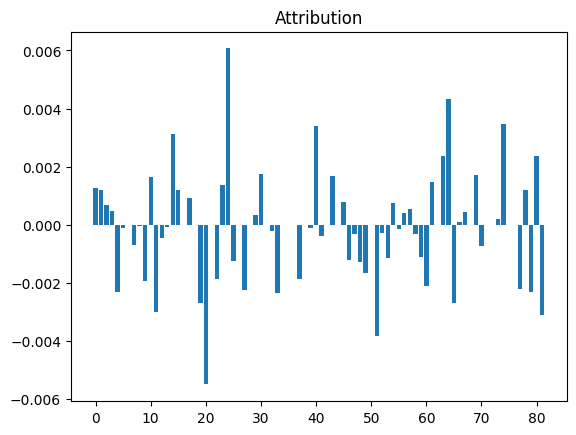

In [39]:
attr = cal_attr(mlp_model, dl[21][2])

plt.title('Attribution')
plt.bar(np.arange(len(attr)),attr)
plt.show